### The dataset Australian Wine Sales contains monthly sales of 3 different varieties of wines (sparkling, sweet white and red) from 1980 January to 1995 July. 
a.	Read the data in R

b.	Smooth the series of sweet white sales with an appropriate moving average. Plot both the original and moving average on the same graph, preferably using different colors.

c.	Do month plot on both sparkling and red wine series. Which is the main difference noted between the two series?

d.	Extract seasonality for both series. Argue which seasonality (additive or multiplicative) will be appropriate for which series. Plot only the seasonality.

e.	Forecast for sparkling wine sales for next 12 months. Explain the model and write down the model parameters.


In [1]:
import sys
import warnings
import itertools
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
%matplotlib inline

In [66]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

### a. Read the data

In [2]:
data = pd.read_csv("AusWineSales.csv")
data.head(5)

,YearMonth,Red,Sparkling,Sweetwhite
0,1980-01,464,1686,85
1,1980-02,675,1591,89
2,1980-03,703,2304,109
3,1980-04,887,1712,95
4,1980-05,1139,1471,91


In [3]:
dates = pd.date_range(start='1980-01-01', freq='MS', periods=len(data))

In [4]:
import calendar
data['Month'] = dates.month
data['Month'] = data['Month'].apply(lambda x: calendar.month_abbr[x])
data['Year'] = dates.year

In [6]:
data.drop(['YearMonth'], axis=1, inplace=True)
#data.rename(columns={'Number of Tractor Sold':'Tractor-Sales'}, inplace=True)
data = data[['Month', 'Year', 'Red','Sparkling','Sweetwhite']]

In [7]:
data.head()

,Month,Year,Red,Sparkling,Sweetwhite
0,Jan,1980,464,1686,85
1,Feb,1980,675,1591,89
2,Mar,1980,703,2304,109
3,Apr,1980,887,1712,95
4,May,1980,1139,1471,91


In [8]:
data.set_index(dates, inplace=True)
data.head()

,Month,Year,Red,Sparkling,Sweetwhite
1980-01-01,Jan,1980,464,1686,85
1980-02-01,Feb,1980,675,1591,89
1980-03-01,Mar,1980,703,2304,109
1980-04-01,Apr,1980,887,1712,95
1980-05-01,May,1980,1139,1471,91


In [9]:
data.tail()

,Month,Year,Red,Sparkling,Sweetwhite
1995-03-01,Mar,1995,2459,1897,188
1995-04-01,Apr,1995,2618,1862,195
1995-05-01,May,1995,2585,1670,189
1995-06-01,Jun,1995,3310,1688,220
1995-07-01,Jul,1995,3923,2031,274


### Stationarity of a Time Series

#### There are three basic criterion for a time series to understand whether it is stationary series or not.

Statistical properties of time series such as mean, variance should remain constant over time to call time series is stationary

constant mean

constant variance

autocovariance that does not depend on time. autocovariance is covariance between time series and lagged time series.

#### Lets visualize and check seasonality trend of our time series.

### Visualize the Time Series

In [11]:
# extract out the time-series
sales_red = data['Red']
sales_spark = data['Sparkling']
sales_white = data['Sweetwhite']

Text(0,0.5,'Red Wine Sales')

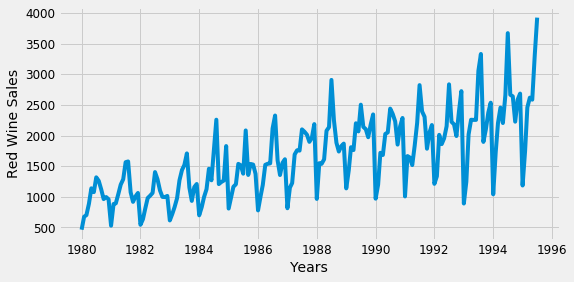

In [67]:
plt.figure(figsize=(8, 4))
plt.plot(sales_red)
plt.xlabel('Years')
plt.ylabel('Red Wine Sales')

Text(0,0.5,'Sparkling Wine Sales')

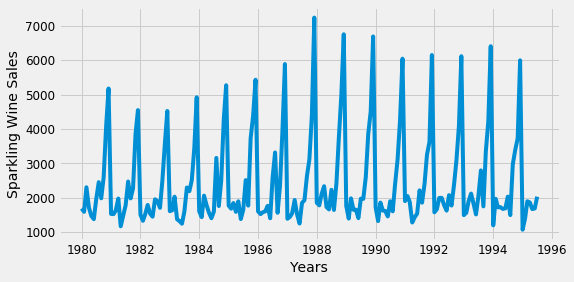

In [68]:
plt.figure(figsize=(8, 4))
plt.plot(sales_spark)
plt.xlabel('Years')
plt.ylabel('Sparkling Wine Sales')

Text(0,0.5,'Sweetwhite Wine Sales')

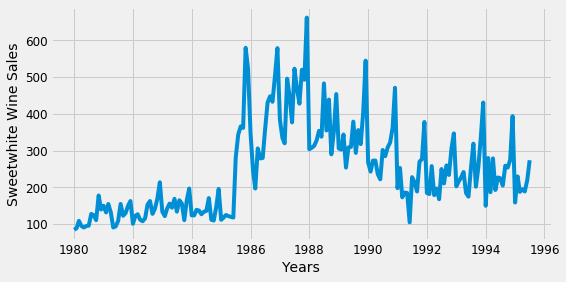

In [69]:
plt.figure(figsize=(8, 4))
plt.plot(sales_white)
plt.xlabel('Years')
plt.ylabel('Sweetwhite Wine Sales')

##### As you can see from plot above, our time series has seasonal variation.

### b. Smooth the series of sweet white sales with an appropriate moving average. Plot both the original and moving average on the same graph, preferably using different colors.

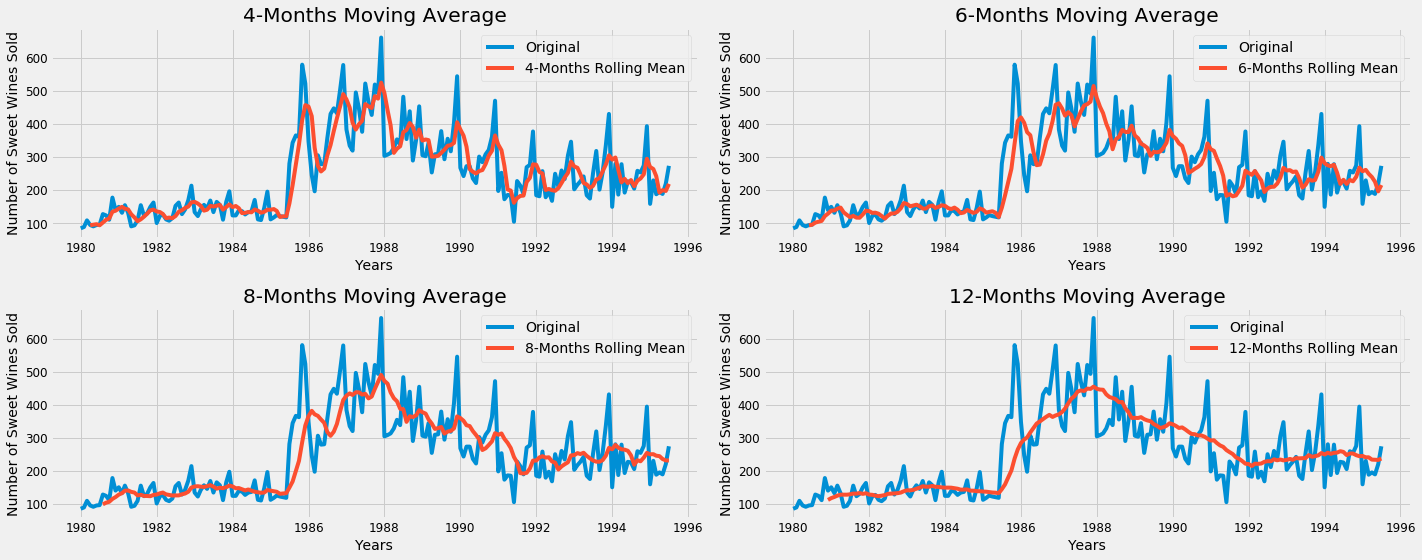

In [95]:
fig, axes = plt.subplots(2, 2, sharey=False, sharex=False)
fig.set_figwidth(20)
fig.set_figheight(8)
axes[0][0].plot(sales_white.index, sales_white, label='Original')
axes[0][0].plot(sales_white.index, sales_white.rolling(window=4).mean(), label='4-Months Rolling Mean')
axes[0][0].set_xlabel("Years")
axes[0][0].set_ylabel("Number of Sweet Wines Sold")
axes[0][0].set_title("4-Months Moving Average")
axes[0][0].legend(loc='best')
axes[0][1].plot(sales_white.index, sales_white, label='Original')
axes[0][1].plot(sales_white.index, sales_white.rolling(window=6).mean(), label='6-Months Rolling Mean')
axes[0][1].set_xlabel("Years")
axes[0][1].set_ylabel("Number of Sweet Wines Sold")
axes[0][1].set_title("6-Months Moving Average")
axes[0][1].legend(loc='best')
axes[1][0].plot(sales_white.index, sales_white, label='Original')
axes[1][0].plot(sales_white.index, sales_white.rolling(window=8).mean(), label='8-Months Rolling Mean')
axes[1][0].set_xlabel("Years")
axes[1][0].set_ylabel("Number of Sweet Wines Sold")
axes[1][0].set_title("8-Months Moving Average")
axes[1][0].legend(loc='best')
axes[1][1].plot(sales_white.index, sales_white, label='Original')
axes[1][1].plot(sales_white.index, sales_white.rolling(window=12).mean(), label='12-Months Rolling Mean')
axes[1][1].set_xlabel("Years")
axes[1][1].set_ylabel("Number of Sweet Wines Sold")
axes[1][1].set_title("12-Months Moving Average")
axes[1][1].legend(loc='best')
plt.tight_layout()
plt.show()

Now lets check stationary of time series. We can check stationarity using the following methods:

#### Plotting Rolling Statistics: We have a window lets say window size is 6 and then we find rolling mean and variance to check stationary.

#### Dickey-Fuller Test: The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the test statistic is less than the critical value, we can say that time series is stationary.

In [24]:
#Determing rolling statistics
rolmean = sales_white.rolling(window=6).mean()
rolstd = sales_white.rolling(window=6).std()

Text(0.5,1,'Rolling Mean & Standard Deviation')

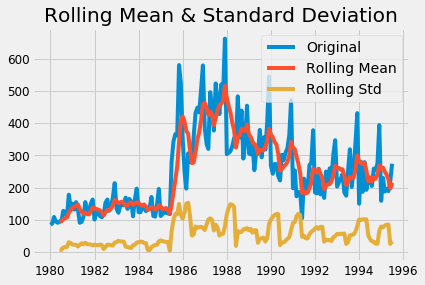

In [71]:
#Plot rolling statistics:
orig = plt.plot(sales_white, label='Original')
mean = plt.plot(rolmean, label='Rolling Mean')
std = plt.plot(rolstd, label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')

### Dickey-Fuller Test:

In [26]:
#define function for ADF test
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#apply adf test on the series
adf_test(sales_white)

Results of Dickey-Fuller Test:
Test Statistic                  -1.717397
p-value                          0.422172
#Lags Used                      13.000000
Number of Observations Used    173.000000
Critical Value (1%)             -3.468726
Critical Value (5%)             -2.878396
Critical Value (10%)            -2.575756
dtype: float64


The test statistic is way more than the critical values. Also, the p value is > 0.05, hence the timeseries is not stationary.

### c. Do month plot on both sparkling and red wine series. Which is the main difference noted between the two series?

In [28]:
monthly_sales_spark = pd.pivot_table(data, values = "Sparkling", columns = "Year", index = "Month")
monthly_sales_red = pd.pivot_table(data, values = "Red", columns = "Year", index = "Month")

In [30]:
monthly_sales_spark

Year,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995
Month,,,,,,,,,,,,,,,,
Apr,1712.0,1976.0,1790.0,1375.0,1789.0,1589.0,1605.0,1935.0,2336.0,1650.0,1628.0,1279.0,1997.0,2121.0,1725.0,1862.0
Aug,2453.0,2472.0,1897.0,2298.0,3159.0,2512.0,3318.0,1930.0,1645.0,1968.0,1605.0,1857.0,1773.0,2795.0,1495.0,NaN
Dec,5179.0,4551.0,4524.0,4923.0,5274.0,5434.0,5891.0,7242.0,6757.0,6694.0,6047.0,6153.0,6119.0,6410.0,5999.0,NaN
Feb,1591.0,1523.0,1329.0,1638.0,1435.0,1682.0,1523.0,1442.0,1779.0,1394.0,1321.0,2049.0,1667.0,1564.0,1968.0,1402.0
Jan,1686.0,1530.0,1510.0,1609.0,1609.0,1771.0,1606.0,1389.0,1853.0,1757.0,1720.0,1902.0,1577.0,1494.0,1197.0,1070.0
Jul,1966.0,1781.0,1954.0,1600.0,1597.0,1645.0,2584.0,1847.0,2230.0,1971.0,1899.0,2214.0,2076.0,2048.0,2031.0,2031.0
Jun,1377.0,1480.0,1449.0,1245.0,1404.0,1379.0,1403.0,1250.0,1661.0,1406.0,1457.0,1540.0,1625.0,1515.0,1693.0,1688.0
Mar,2304.0,1633.0,1518.0,2030.0,2061.0,1846.0,1577.0,1548.0,2108.0,1982.0,1859.0,1874.0,1993.0,1898.0,1720.0,1897.0
May,1471.0,1170.0,1537.0,1320.0,1567.0,1896.0,1765.0,1518.0,1728.0,1654.0,1615.0,1432.0,1783.0,1831.0,1674.0,1670.0


In [31]:
monthly_sales_red

Year,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995
Month,,,,,,,,,,,,,,,,
Apr,887.0,1045.0,980.0,977.0,1124.0,1205.0,1522.0,1691.0,1612.0,1763.0,1683.0,1518.0,1860.0,2257.0,2455.0,2618.0
Aug,1260.0,1577.0,1286.0,1708.0,2258.0,2083.0,2326.0,2062.0,2249.0,2141.0,2353.0,2393.0,2224.0,3330.0,2665.0,NaN
Dec,960.0,1063.0,1015.0,1209.0,1828.0,1376.0,1613.0,2186.0,1868.0,2344.0,2286.0,2171.0,2724.0,2535.0,2684.0,NaN
Feb,675.0,883.0,635.0,722.0,830.0,997.0,1005.0,1150.0,1549.0,1430.0,1199.0,1665.0,1335.0,1247.0,1728.0,1749.0
Jan,464.0,530.0,544.0,615.0,699.0,809.0,779.0,814.0,966.0,1138.0,970.0,1007.0,1212.0,891.0,1041.0,1185.0
Jul,1318.0,1565.0,1404.0,1520.0,1753.0,1378.0,2116.0,2100.0,2907.0,2503.0,2439.0,2822.0,2835.0,3057.0,3670.0,3923.0
Jun,1077.0,1287.0,1064.0,1437.0,1270.0,1513.0,1546.0,1754.0,2137.0,2067.0,2051.0,2207.0,2152.0,2255.0,2660.0,3310.0
Mar,703.0,894.0,804.0,832.0,996.0,1164.0,1193.0,1225.0,1538.0,1809.0,1718.0,1642.0,2011.0,2017.0,2201.0,2459.0
May,1139.0,1199.0,1018.0,1270.0,1458.0,1538.0,1539.0,1759.0,2078.0,2200.0,2025.0,1831.0,1954.0,2255.0,2204.0,2585.0


In [32]:
monthly_sales_spark = monthly_sales_spark.reindex(index = ['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
monthly_sales_spark

Year,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995
Month,,,,,,,,,,,,,,,,
Jan,1686.0,1530.0,1510.0,1609.0,1609.0,1771.0,1606.0,1389.0,1853.0,1757.0,1720.0,1902.0,1577.0,1494.0,1197.0,1070.0
Feb,1591.0,1523.0,1329.0,1638.0,1435.0,1682.0,1523.0,1442.0,1779.0,1394.0,1321.0,2049.0,1667.0,1564.0,1968.0,1402.0
Mar,2304.0,1633.0,1518.0,2030.0,2061.0,1846.0,1577.0,1548.0,2108.0,1982.0,1859.0,1874.0,1993.0,1898.0,1720.0,1897.0
Apr,1712.0,1976.0,1790.0,1375.0,1789.0,1589.0,1605.0,1935.0,2336.0,1650.0,1628.0,1279.0,1997.0,2121.0,1725.0,1862.0
May,1471.0,1170.0,1537.0,1320.0,1567.0,1896.0,1765.0,1518.0,1728.0,1654.0,1615.0,1432.0,1783.0,1831.0,1674.0,1670.0
Jun,1377.0,1480.0,1449.0,1245.0,1404.0,1379.0,1403.0,1250.0,1661.0,1406.0,1457.0,1540.0,1625.0,1515.0,1693.0,1688.0
Jul,1966.0,1781.0,1954.0,1600.0,1597.0,1645.0,2584.0,1847.0,2230.0,1971.0,1899.0,2214.0,2076.0,2048.0,2031.0,2031.0
Aug,2453.0,2472.0,1897.0,2298.0,3159.0,2512.0,3318.0,1930.0,1645.0,1968.0,1605.0,1857.0,1773.0,2795.0,1495.0,NaN
Sep,1984.0,1981.0,1706.0,2191.0,1759.0,1771.0,1562.0,2638.0,2421.0,2608.0,2424.0,2408.0,2377.0,1749.0,2968.0,NaN


In [33]:
monthly_sales_red = monthly_sales_red.reindex(index = ['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
monthly_sales_red

Year,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995
Month,,,,,,,,,,,,,,,,
Jan,464.0,530.0,544.0,615.0,699.0,809.0,779.0,814.0,966.0,1138.0,970.0,1007.0,1212.0,891.0,1041.0,1185.0
Feb,675.0,883.0,635.0,722.0,830.0,997.0,1005.0,1150.0,1549.0,1430.0,1199.0,1665.0,1335.0,1247.0,1728.0,1749.0
Mar,703.0,894.0,804.0,832.0,996.0,1164.0,1193.0,1225.0,1538.0,1809.0,1718.0,1642.0,2011.0,2017.0,2201.0,2459.0
Apr,887.0,1045.0,980.0,977.0,1124.0,1205.0,1522.0,1691.0,1612.0,1763.0,1683.0,1518.0,1860.0,2257.0,2455.0,2618.0
May,1139.0,1199.0,1018.0,1270.0,1458.0,1538.0,1539.0,1759.0,2078.0,2200.0,2025.0,1831.0,1954.0,2255.0,2204.0,2585.0
Jun,1077.0,1287.0,1064.0,1437.0,1270.0,1513.0,1546.0,1754.0,2137.0,2067.0,2051.0,2207.0,2152.0,2255.0,2660.0,3310.0
Jul,1318.0,1565.0,1404.0,1520.0,1753.0,1378.0,2116.0,2100.0,2907.0,2503.0,2439.0,2822.0,2835.0,3057.0,3670.0,3923.0
Aug,1260.0,1577.0,1286.0,1708.0,2258.0,2083.0,2326.0,2062.0,2249.0,2141.0,2353.0,2393.0,2224.0,3330.0,2665.0,NaN
Sep,1120.0,1076.0,1104.0,1151.0,1208.0,1357.0,1596.0,2012.0,1883.0,2103.0,2230.0,2306.0,2182.0,1896.0,2639.0,NaN


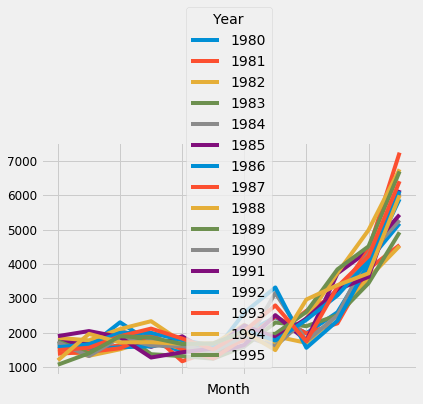

In [72]:
monthly_sales_spark.plot()

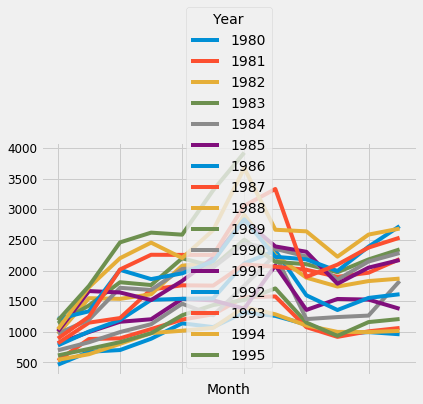

In [73]:
monthly_sales_red.plot()

In [37]:
yearly_sales_spark = pd.pivot_table(data, values = "Sparkling", columns = "Month", index = "Year")
yearly_sales_spark = yearly_sales_spark[['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]

yearly_sales_red = pd.pivot_table(data, values = "Red", columns = "Month", index = "Year")
yearly_sales_red = yearly_sales_red[['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]


In [38]:
yearly_sales_spark

Month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1980,1686.0,1591.0,2304.0,1712.0,1471.0,1377.0,1966.0,2453.0,1984.0,2596.0,4087.0,5179.0
1981,1530.0,1523.0,1633.0,1976.0,1170.0,1480.0,1781.0,2472.0,1981.0,2273.0,3857.0,4551.0
1982,1510.0,1329.0,1518.0,1790.0,1537.0,1449.0,1954.0,1897.0,1706.0,2514.0,3593.0,4524.0
1983,1609.0,1638.0,2030.0,1375.0,1320.0,1245.0,1600.0,2298.0,2191.0,2511.0,3440.0,4923.0
1984,1609.0,1435.0,2061.0,1789.0,1567.0,1404.0,1597.0,3159.0,1759.0,2504.0,4273.0,5274.0
1985,1771.0,1682.0,1846.0,1589.0,1896.0,1379.0,1645.0,2512.0,1771.0,3727.0,4388.0,5434.0
1986,1606.0,1523.0,1577.0,1605.0,1765.0,1403.0,2584.0,3318.0,1562.0,2349.0,3987.0,5891.0
1987,1389.0,1442.0,1548.0,1935.0,1518.0,1250.0,1847.0,1930.0,2638.0,3114.0,4405.0,7242.0
1988,1853.0,1779.0,2108.0,2336.0,1728.0,1661.0,2230.0,1645.0,2421.0,3740.0,4988.0,6757.0


In [39]:
yearly_sales_red

Month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1980,464.0,675.0,703.0,887.0,1139.0,1077.0,1318.0,1260.0,1120.0,963.0,996.0,960.0
1981,530.0,883.0,894.0,1045.0,1199.0,1287.0,1565.0,1577.0,1076.0,918.0,1008.0,1063.0
1982,544.0,635.0,804.0,980.0,1018.0,1064.0,1404.0,1286.0,1104.0,999.0,996.0,1015.0
1983,615.0,722.0,832.0,977.0,1270.0,1437.0,1520.0,1708.0,1151.0,934.0,1159.0,1209.0
1984,699.0,830.0,996.0,1124.0,1458.0,1270.0,1753.0,2258.0,1208.0,1241.0,1265.0,1828.0
1985,809.0,997.0,1164.0,1205.0,1538.0,1513.0,1378.0,2083.0,1357.0,1536.0,1526.0,1376.0
1986,779.0,1005.0,1193.0,1522.0,1539.0,1546.0,2116.0,2326.0,1596.0,1356.0,1553.0,1613.0
1987,814.0,1150.0,1225.0,1691.0,1759.0,1754.0,2100.0,2062.0,2012.0,1897.0,1964.0,2186.0
1988,966.0,1549.0,1538.0,1612.0,2078.0,2137.0,2907.0,2249.0,1883.0,1739.0,1828.0,1868.0


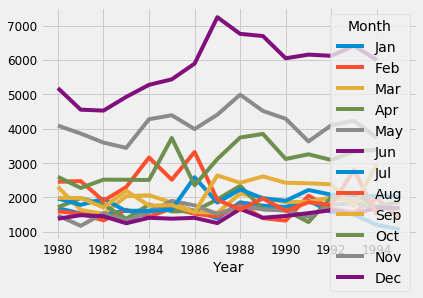

In [94]:
yearly_sales_spark.plot()

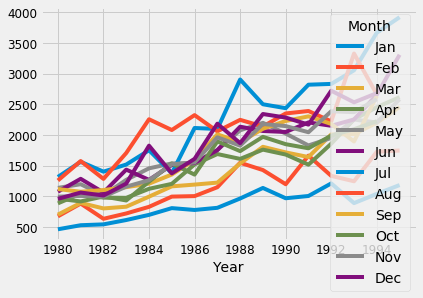

In [75]:
yearly_sales_red.plot()

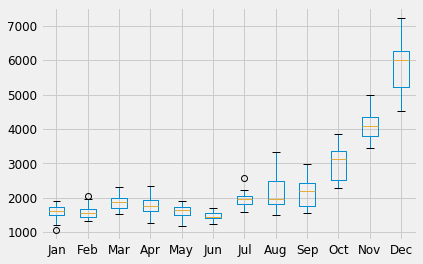

In [76]:
yearly_sales_spark.boxplot()

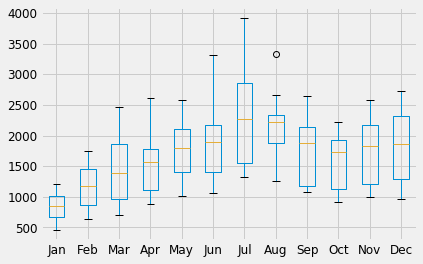

In [77]:
yearly_sales_red.boxplot()

#### Inferences:

1. The Sparkling wine sales have been increasing in the winter every year.
Nov & December are the peak months for Sparkling Wine sales and the variance and the mean value for those months are also much higher than any of the other months.
We can see a seasonal effect with a cycle of 12 months.

2. The Red wine sales have been increasing in the summer every year.
July & August are the peak months for Red Wine sales and the variance and the mean value for those months are also much higher than any of the other months.
We can see a seasonal effect with a cycle of 12 months.

### d. Extract seasonality for both series. Argue which seasonality (additive or multiplicative) will be appropriate for which series. Plot only the seasonality.

In [44]:
decomposition_spark_m = sm.tsa.seasonal_decompose(sales_spark, model='multiplicative')
decomposition_spark_a = sm.tsa.seasonal_decompose(sales_spark, model='additive')

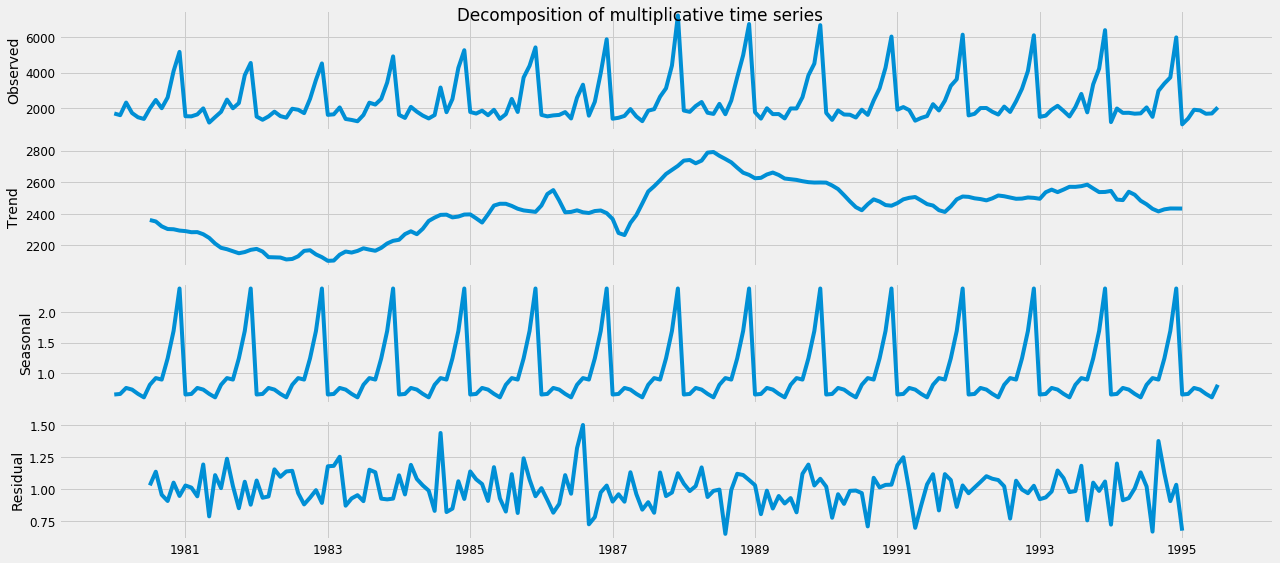

In [99]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
fig = decomposition_spark_m.plot()
fig.suptitle('Decomposition of multiplicative time series')
plt.show()

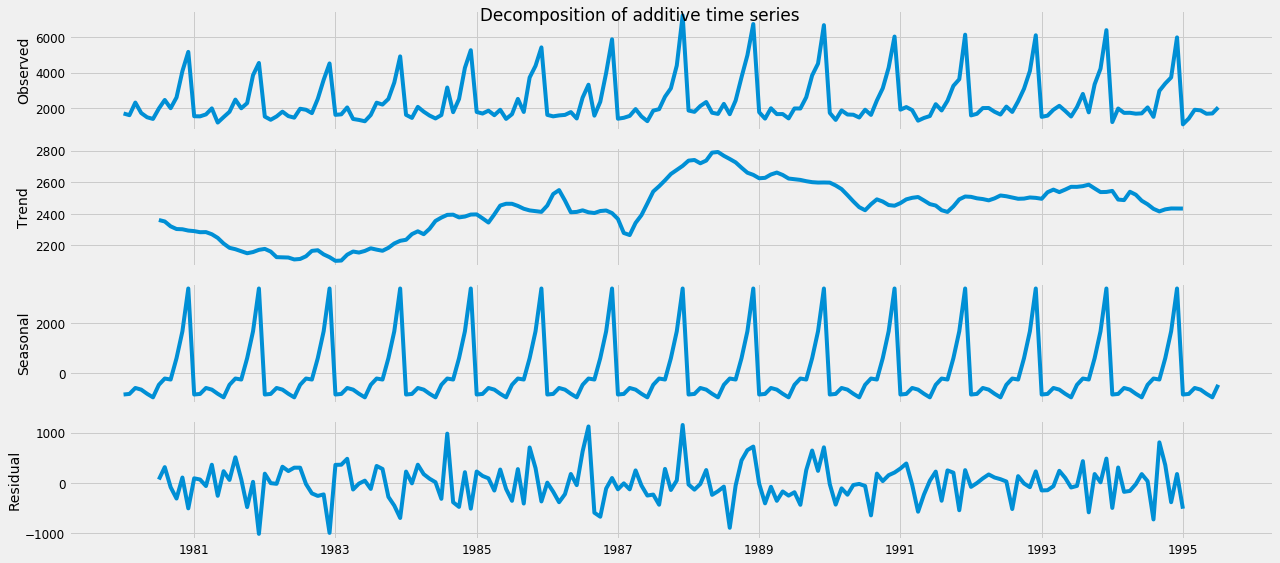

In [98]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
fig = decomposition_spark_a.plot()
fig.suptitle('Decomposition of additive time series')
plt.show()

In [49]:
decomposition_red_m = sm.tsa.seasonal_decompose(sales_red, model='multiplicative')
decomposition_red_a = sm.tsa.seasonal_decompose(sales_red, model='additive')

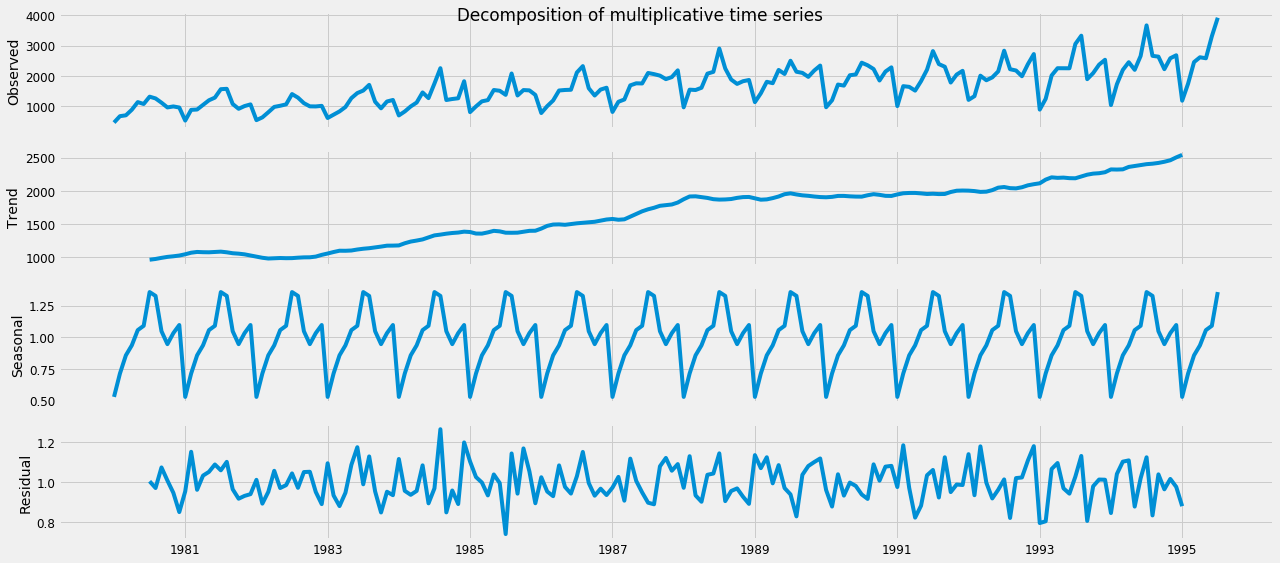

In [97]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
fig = decomposition_red_m.plot()
fig.suptitle('Decomposition of multiplicative time series')
plt.show()

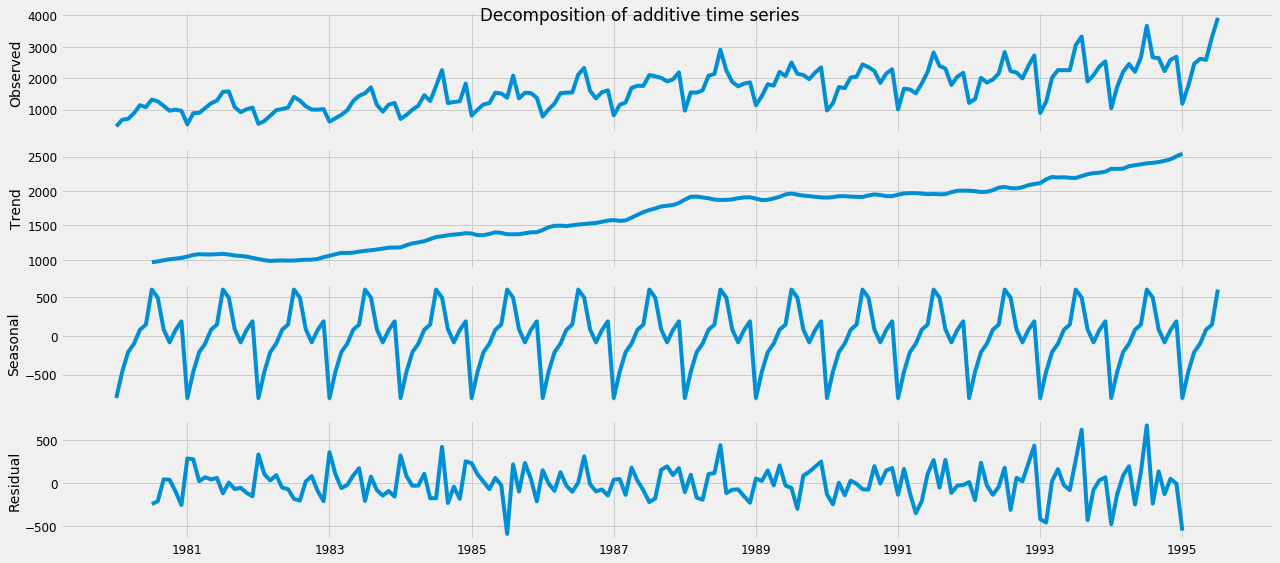

In [96]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
fig = decomposition_red_a.plot()
fig.suptitle('Decomposition of additive time series')
plt.show()

We can see an additive trend in seasonality for both Sparkling & Red Wine.

In [52]:
seasonal_spark = decomposition_spark_a.seasonal
seasonal_spark.head(24)

1980-01-01    -854.260599
1980-02-01    -830.350678
1980-03-01    -592.356630
1980-04-01    -658.490559
1980-05-01    -824.416154
1980-06-01    -967.434011
1980-07-01    -465.502265
1980-08-01    -214.332821
1980-09-01    -254.677265
1980-10-01     599.769957
1980-11-01    1675.067179
1980-12-01    3386.983846
1981-01-01    -854.260599
1981-02-01    -830.350678
1981-03-01    -592.356630
1981-04-01    -658.490559
1981-05-01    -824.416154
1981-06-01    -967.434011
1981-07-01    -465.502265
1981-08-01    -214.332821
1981-09-01    -254.677265
1981-10-01     599.769957
1981-11-01    1675.067179
1981-12-01    3386.983846
Freq: MS, Name: Sparkling, dtype: float64

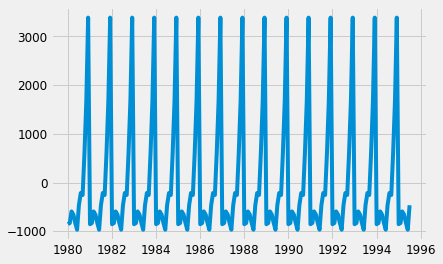

In [82]:
plt.plot(seasonal_spark)
plt.show()

In [55]:
seasonal_red = decomposition_red_a.seasonal
seasonal_red.head(24)

1980-01-01   -803.281994
1980-02-01   -463.740129
1980-03-01   -210.371081
1980-04-01   -100.936558
1980-05-01     78.858085
1980-06-01    145.566419
1980-07-01    597.534673
1980-08-01    494.415228
1980-09-01     83.087450
1980-10-01    -83.731994
1980-11-01     74.976339
1980-12-01    187.623562
1981-01-01   -803.281994
1981-02-01   -463.740129
1981-03-01   -210.371081
1981-04-01   -100.936558
1981-05-01     78.858085
1981-06-01    145.566419
1981-07-01    597.534673
1981-08-01    494.415228
1981-09-01     83.087450
1981-10-01    -83.731994
1981-11-01     74.976339
1981-12-01    187.623562
Freq: MS, Name: Red, dtype: float64

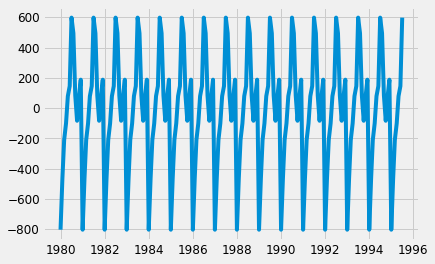

In [83]:
plt.plot(seasonal_red)
plt.show()

### e. Forecast for sparkling wine sales for next 12 months. Explain the model and write down the model parameters.

Text(0,0.5,'Sparkling Wine Sales')

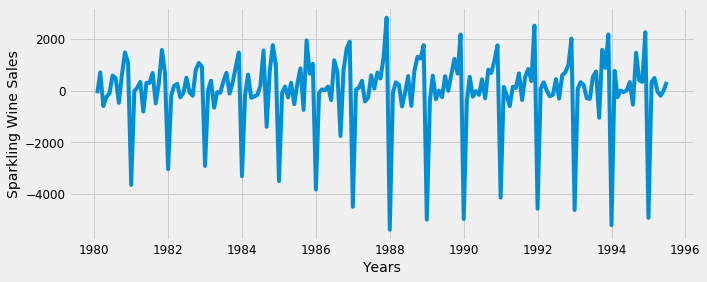

In [85]:
plt.figure(figsize=(10, 4))
plt.plot(sales_spark.diff(periods=1))
plt.xlabel('Years')
plt.ylabel('Sparkling Wine Sales')

Text(0,0.5,'Log (Sparkling Wine Sales)')

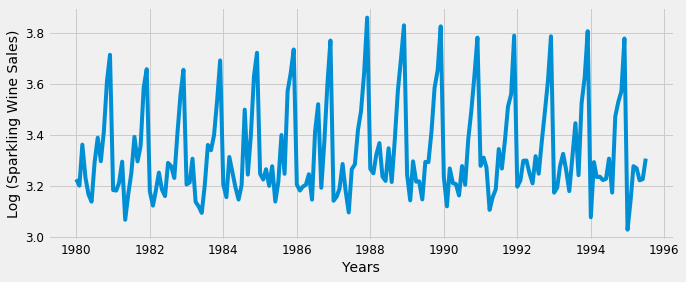

In [86]:
plt.figure(figsize=(10, 4))
plt.plot(np.log10(sales_spark))
plt.xlabel('Years')
plt.ylabel('Log (Sparkling Wine Sales)')

In [100]:
sales_spark_log = np.log10(sales_spark)
sales_spark_log.dropna(inplace=True)

sales_spark_log_diff = sales_spark_log.diff(periods=1) 
sales_spark_log_diff.dropna(inplace=True)

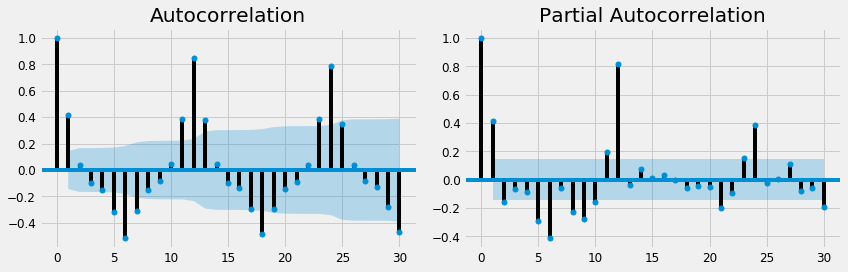

In [101]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(sales_spark_log, lags=30, ax=axes[0])
smt.graphics.plot_pacf(sales_spark_log, lags=30, ax=axes[1])
plt.tight_layout()

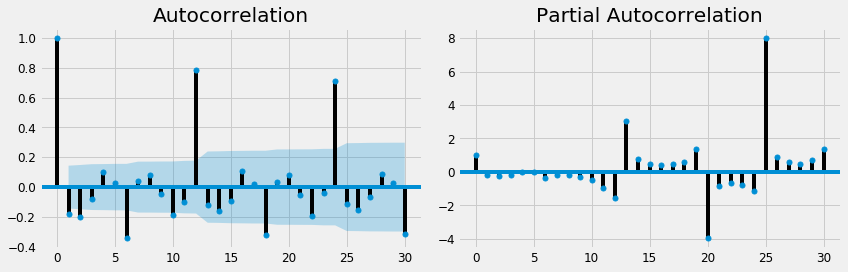

In [102]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(sales_spark_log_diff, lags=30, ax=axes[0])
smt.graphics.plot_pacf(sales_spark_log_diff, lags=30, ax=axes[1])
plt.tight_layout()

In [107]:
adf_test(sales_spark_log_diff)

Results of Dickey-Fuller Test:
Test Statistic                 -31.861733
p-value                          0.000000
#Lags Used                      10.000000
Number of Observations Used    175.000000
Critical Value (1%)             -3.468280
Critical Value (5%)             -2.878202
Critical Value (10%)            -2.575653
dtype: float64


In [119]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [135]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [122]:
#Separate data into train and test
data['date'] = data.index
train = data[data.index < '1992-01-01']
test = data[data.index >= '1992-01-01']
train_sales_spark_log = np.log10(train['Sparkling'])

In [136]:
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

In [142]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        
        try:
            temp_model = sm.tsa.statespace.SARIMAX(train_sales_spark_log,
                                             order = param,
                                             seasonal_order = param_seasonal,
                                             enforce_stationarity=True)
            results = temp_model.fit()

            # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            #print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAX(1, 1, 1)x(1, 0, 1, 12)12 model - AIC:-328.82192296501114


### Predict sales on in-sample date using the best fit ARIMA model

In [176]:
best_model = sm.tsa.statespace.SARIMAX(train_sales_spark_log,
                                      order=(1, 1, 1),
                                      seasonal_order=(0, 1, 1, 12),
                                      enforce_stationarity=True)
best_results = best_model.fit()

In [177]:
print(best_results.summary().tables[0])
print(best_results.summary().tables[1])

                                 Statespace Model Results                                 
Dep. Variable:                          Sparkling   No. Observations:                  144
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 163.070
Date:                            Fri, 28 Dec 2018   AIC                           -318.140
Time:                                    13:30:35   BIC                           -306.639
Sample:                                01-01-1980   HQIC                          -313.467
                                     - 12-01-1991                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0949      0.096      0.988      0.323      -0.093       0.283
ma.L1         -0.9398      0.039   

### comparing our model with a random order model

In [189]:
param_order = (0, 1, 1)
param_seasonal_order = (0, 1, 1, 12)
model = sm.tsa.statespace.SARIMAX(train_sales_spark_log, order=param_order, 
                                  seasonal_order=param_seasonal_order,enforce_stationarity=True)
results = model.fit()
print("SARIMAX{}x{}12 model - AIC:{}".format(param_order, param_seasonal_order, results.aic))

SARIMAX(0, 1, 1)x(0, 1, 1, 12)12 model - AIC:-319.22627620643107


In [178]:
pred_dynamic = best_results.get_prediction(start=pd.to_datetime('1991-01-01'), dynamic=True, full_results=True)

In [179]:
pred_dynamic_ci = pred_dynamic.conf_int()

In [180]:
pred99 = best_results.get_forecast(steps=48, alpha=0.1)

In [181]:
# Extract the predicted and true values of our time series
sales_spark_forecasted = pred_dynamic.predicted_mean
testCopy = test.copy()
testCopy['Sparkling_forecasted'] = np.power(10, pred99.predicted_mean)

In [167]:
testCopy

,Month,Year,Red,Sparkling,Sweetwhite,date,Sparkling_forecasted
1992-01-01,Jan,1992,1212,1577,185,1992-01-01,1827.966562
1992-02-01,Feb,1992,1335,1667,182,1992-02-01,1710.582575
1992-03-01,Mar,1992,2011,1993,258,1992-03-01,1913.747424
1992-04-01,Apr,1992,1860,1997,179,1992-04-01,1560.090706
1992-05-01,May,1992,1954,1783,197,1992-05-01,1584.659823
1992-06-01,Jun,1992,2152,1625,168,1992-06-01,1527.295724
1992-07-01,Jul,1992,2835,2076,250,1992-07-01,2102.727965
1992-08-01,Aug,1992,2224,1773,211,1992-08-01,1871.252887
1992-09-01,Sep,1992,2182,2377,260,1992-09-01,2425.418884
1992-10-01,Oct,1992,1992,3088,234,1992-10-01,3279.668722


In [182]:
# Compute the root mean square error
mse = ((testCopy['Sparkling'] - testCopy['Sparkling_forecasted']) ** 2).mean()
rmse = np.sqrt(mse)
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 3)))

The Root Mean Squared Error of our forecasts is 311.174


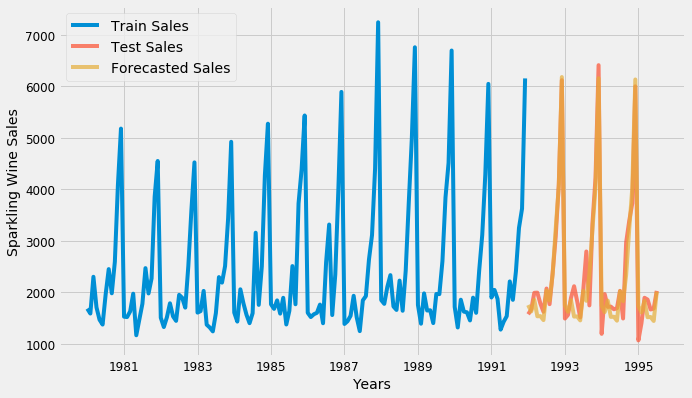

In [183]:
axis = train['Sparkling'].plot(label='Train Sales', figsize=(10, 6))
testCopy['Sparkling'].plot(ax=axis, label='Test Sales', alpha=0.7)
testCopy['Sparkling_forecasted'].plot(ax=axis, label='Forecasted Sales', alpha=0.7)
axis.set_xlabel('Years')
axis.set_ylabel('Sparkling Wine Sales')
plt.legend(loc='best')
plt.show()
plt.close()

### Forecast sales using the best fit ARIMA model

In [185]:
# Get forecast 36 steps (3 years) ahead in future
n_steps = 36
pred_uc_99 = best_results.get_forecast(steps=36, alpha=0.01) # alpha=0.01 signifies 99% confidence interval
pred_uc_95 = best_results.get_forecast(steps=36, alpha=0.05) # alpha=0.05 95% CI

# Get confidence intervals 95% & 99% of the forecasts
pred_ci_99 = pred_uc_99.conf_int()
pred_ci_95 = pred_uc_95.conf_int()

In [186]:
n_steps = 36
idx = pd.date_range(data.index[-1], periods=n_steps, freq='MS')
fc_95 = pd.DataFrame(np.column_stack([np.power(10, pred_uc_95.predicted_mean), np.power(10, pred_ci_95)]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([np.power(10, pred_ci_99)]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all = fc_all[['forecast', 'lower_ci_95', 'upper_ci_95', 'lower_ci_99', 'upper_ci_99']] # just reordering columns
fc_all.head()

,forecast,lower_ci_95,upper_ci_95,lower_ci_99,upper_ci_99
1995-07-01,1755.500630,1294.775715,2380.167024,1294.775715,2380.167024
1995-08-01,1631.157636,1198.696450,2219.640536,1198.696450,2219.640536
1995-09-01,1856.937193,1363.466091,2529.007332,1363.466091,2529.007332
1995-10-01,1537.849136,1128.407563,2095.856181,1128.407563,2095.856181
1995-11-01,1541.003541,1129.972650,2101.548134,1129.972650,2101.548134


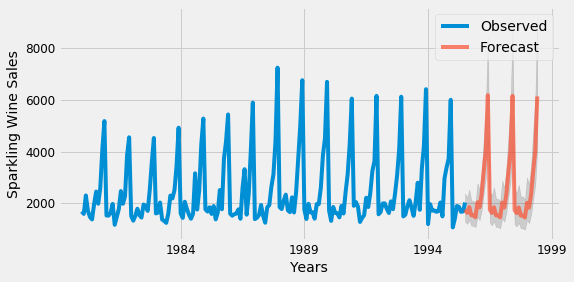

In [187]:
# plot the forecast along with the confidence band
axis = sales_spark.plot(label='Observed', figsize=(8, 4))
fc_all['forecast'].plot(ax=axis, label='Forecast', alpha=0.7)
axis.fill_between(fc_all.index, fc_all['lower_ci_95'], fc_all['upper_ci_95'], color='k', alpha=.15)
axis.set_xlabel('Years')
axis.set_ylabel('Sparkling Wine Sales')
plt.legend(loc='best')
plt.show()

### Plot ACF and PACF for residuals of ARIMA model to ensure no more information is left for extraction

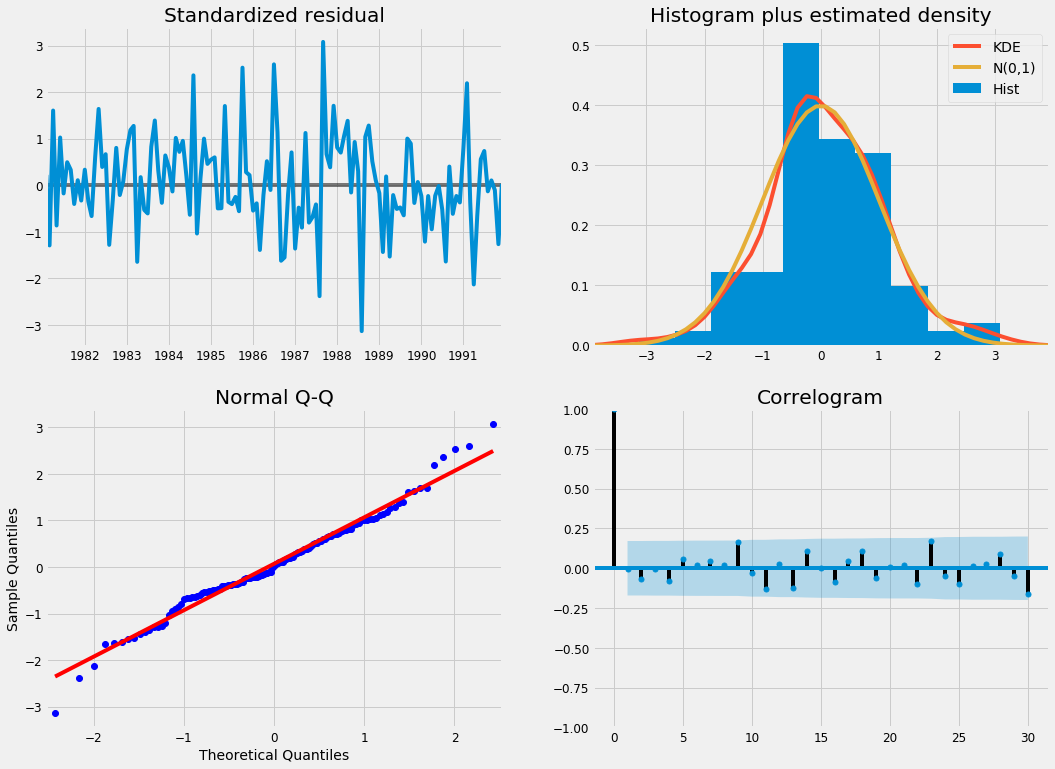

In [188]:
best_results.plot_diagnostics(lags=30, figsize=(16,12))
plt.show()

We need to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If it is not that it signifies that the model can be further improved and we repeat the process with the residuals.

1. KDE plot is almost close to normal distribution.
2. The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.
3. The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

Those observations coupled with the fact that there are no spikes outside the insignificant zone for both ACF and PACF plots lead us to conclude that that residuals are random with no information or juice in them and our model produces a satisfactory fit that could help us understand our time series data and forecast future values. It sems that our ARIMA model is working fine.

ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data: 

Our best fit model had the parameters as (1, 1, 1)x(0, 1, 1, 12)12. The differential here is of order 1.